In [1]:
import numpy as np
import json
from scipy.stats import pearsonr
from tqdm import tqdm
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
dataset_path = os.getenv("DATASET_PATH")
instruments = os.getenv("INSTRUMENTS").split(",")

In [3]:
with open(os.path.join(dataset_path, "dataset_metadata.json"), "r") as f:
    dataset_metadata = json.load(f)

In [4]:
instruments = os.getenv("INSTRUMENTS").split(",")
for artist, songs in list(dataset_metadata.items()):
    for song in list(songs.keys()):
        if dataset_metadata[artist][song]["layout"] != instruments:
            print(f"Removing {artist} - {song}: layout mismatch")
            del dataset_metadata[artist][song]
        
        elif dataset_metadata[artist][song]["face_detected"] != True or dataset_metadata[artist][song]["body_detected"] != True:
            print(f"Removing {artist} - {song}: no face or body detected")
            del dataset_metadata[artist][song]

    if len(dataset_metadata[artist]) == 0:
        del dataset_metadata[artist]


Removing Abhiram Bode - Devi Pavane: no face or body detected
Removing Abhiram Bode - Nadatina: no face or body detected
Removing Abhishek Ravi Shankar - Brindavanam Idhuvo: layout mismatch
Removing Abhishek Ravi Shankar - Kamakshi Varlakshmi: layout mismatch
Removing Abhishek Ravi Shankar - Manasa Etulo: layout mismatch
Removing Abhishek Ravi Shankar - Palaya Sada: layout mismatch
Removing Abhishek Ravi Shankar - Sami Ninne: layout mismatch
Removing Abhishek Ravi Shankar - Tappagane Vachunna: layout mismatch
Removing Aditi Prahalad - Parama Pavana Rama: no face or body detected
Removing Aditya Narayanan - Chittam Irangadhe: layout mismatch
Removing Aditya Narayanan - Koluvamaragada: layout mismatch
Removing Aditya Narayanan - Sarasaksha Palaya: layout mismatch
Removing Ameya Karthikeyan - Jalajakshi: no face or body detected
Removing Ameya Karthikeyan - Saraguna Palimpa: no face or body detected
Removing Ameya Karthikeyan - iniyagilum ninai: layout mismatch
Removing Anjanathirumalai -

### Loading audio & motion features

In [5]:
motion_features = {}
audio_features = {}

for artist, songs in tqdm(dataset_metadata.items(), desc="Artists"):
    artist_dir = os.path.join(dataset_path, artist)
    if not os.path.isdir(artist_dir) or artist.startswith("."):
        continue

    motion_features.setdefault(artist, {})
    audio_features.setdefault(artist, {})

    for song in tqdm(songs, desc="Songs", leave=False):
        song_dir = os.path.join(artist_dir, song)
        if not os.path.isdir(song_dir) or song.startswith("."):
            continue

        motion_features[artist].setdefault(song, {})
        audio_features[artist].setdefault(song, {})

        for instrument in instruments:
            instrument_dir = os.path.join(song_dir, instrument)
            if not os.path.exists(instrument_dir):
                continue

            motion_features[artist][song].setdefault(instrument, {})
            audio_features[artist][song].setdefault(instrument, {})

            try:
                with open(
                    os.path.join(instrument_dir, "motion_features_normalized_occluded.json"), "r"
                ) as f:
                    motion_features[artist][song][instrument] = json.load(f)
                with open(
                    os.path.join(instrument_dir, "audio_features.json"), "r"
                ) as f:
                    audio_features[artist][song][instrument] = json.load(f)
            except FileNotFoundError:
                print(
                    f"File not found for {artist}/{song}/{instrument}. Skipping this instrument."
                )
                continue

Artists: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]


In [6]:
def safe_pearsonr(x, y):
    """
    Compute Pearson correlation between x and y, ignoring NaNs.

    Returns (corr, pval). If too few valid values, returns (np.nan, np.nan).
    """
    x = np.array(x)
    y = np.array(y)
    mask = ~np.isnan(x) & ~np.isnan(y)
    if np.sum(mask) < 2:  # need at least 2 points to compute correlation
        return np.nan, np.nan
    return pearsonr(x[mask], y[mask])

### Global speed & acceleration vs gesture correlations 

In [7]:
speed_relevant_correlations = []

for artist in motion_features.keys():
    for song in motion_features[artist].keys():
        for instrument in motion_features[artist][song].keys():
            for body_part in motion_features[artist][song][instrument].keys():
                try:
                    corr, pval = safe_pearsonr(
                        motion_features[artist][song][instrument][body_part][
                            "mean_acceleration"
                        ],
                        audio_features[artist][song][instrument]["onset_env"],
                    )

                    if corr > 0.25 and pval < 0.05:
                        speed_relevant_correlations.append(
                            {
                                "artist": artist,
                                "song": song,
                                "instrument": instrument,
                                "body_part": body_part,
                                "corr": float(corr),
                            }
                        )
                except Exception as e:
                    print(
                        f"Error processing {artist}, {song}, {instrument}, {body_part}: {e}"
                    )

In [8]:
speed_relevant_correlations

[{'artist': 'Anjanathirumalai',
  'song': 'Marivere Dikkevaru',
  'instrument': 'vocal',
  'body_part': 'general',
  'corr': 0.27920665893501945},
 {'artist': 'Anjanathirumalai',
  'song': 'Marivere Dikkevaru',
  'instrument': 'vocal',
  'body_part': 'right_arm',
  'corr': 0.31292547256781034},
 {'artist': 'Anjanathirumalai',
  'song': 'Marivere Dikkevaru',
  'instrument': 'vocal',
  'body_part': 'right_hand',
  'corr': 0.3454825095211761},
 {'artist': 'Manickam Yogeswaran',
  'song': 'Thillana',
  'instrument': 'mridangam',
  'body_part': 'right_hand',
  'corr': 0.31342628398495403},
 {'artist': 'Raghav Krishna',
  'song': 'Rama Rama Gunaseema',
  'instrument': 'mridangam',
  'body_part': 'general',
  'corr': 0.2612433693357753},
 {'artist': 'Raghav Krishna',
  'song': 'Rama Rama Gunaseema',
  'instrument': 'mridangam',
  'body_part': 'right_hand',
  'corr': 0.3187258231443978},
 {'artist': 'Raghav Krishna',
  'song': 'Rama Rama Gunaseema',
  'instrument': 'vocal',
  'body_part': 'lef

In [9]:
acceleration_relevant_correlations = []

for artist in motion_features.keys():
    for song in motion_features[artist].keys():
        for instrument in motion_features[artist][song].keys():
            for body_part in motion_features[artist][song][instrument].keys():
                try:
                    corr, pval = safe_pearsonr(
                        motion_features[artist][song][instrument][body_part][
                            "mean_acceleration"
                        ],
                        audio_features[artist][song][instrument]["onset_env"],
                    )

                    if corr > 0.25 and pval < 0.05:
                        acceleration_relevant_correlations.append(
                            {
                                "artist": artist,
                                "song": song,
                                "instrument": instrument,
                                "body_part": body_part,
                                "corr": float(corr),
                            }
                        )
                except Exception as e:
                    print(
                        f"Error processing {artist}, {song}, {instrument}, {body_part}: {e}"
                    )

In [10]:
acceleration_relevant_correlations

[{'artist': 'Anjanathirumalai',
  'song': 'Marivere Dikkevaru',
  'instrument': 'vocal',
  'body_part': 'general',
  'corr': 0.27920665893501945},
 {'artist': 'Anjanathirumalai',
  'song': 'Marivere Dikkevaru',
  'instrument': 'vocal',
  'body_part': 'right_arm',
  'corr': 0.31292547256781034},
 {'artist': 'Anjanathirumalai',
  'song': 'Marivere Dikkevaru',
  'instrument': 'vocal',
  'body_part': 'right_hand',
  'corr': 0.3454825095211761},
 {'artist': 'Manickam Yogeswaran',
  'song': 'Thillana',
  'instrument': 'mridangam',
  'body_part': 'right_hand',
  'corr': 0.31342628398495403},
 {'artist': 'Raghav Krishna',
  'song': 'Rama Rama Gunaseema',
  'instrument': 'mridangam',
  'body_part': 'general',
  'corr': 0.2612433693357753},
 {'artist': 'Raghav Krishna',
  'song': 'Rama Rama Gunaseema',
  'instrument': 'mridangam',
  'body_part': 'right_hand',
  'corr': 0.3187258231443978},
 {'artist': 'Raghav Krishna',
  'song': 'Rama Rama Gunaseema',
  'instrument': 'vocal',
  'body_part': 'lef

### Local speed & acceleration vs gesture correlations

In [11]:
def sliding_correlation(
    signal1, signal2, window_size, step_size, fps, threshold=0.3
):
    assert len(signal1) == len(signal2), "Signals must be the same length"

    correlations = []
    pvals = []
    times = []
    for start in range(0, len(signal1) - window_size + 1, step_size):
        end = start + window_size
        seg1 = signal1[start:end]
        seg2 = signal2[start:end]

        corr, pval = safe_pearsonr(seg1, seg2)
        correlations.append(corr)
        pvals.append(pval)
        times.append(start / fps)

    strong_corr_times = [
        (t,c)
        for t, c, p in zip(times, correlations, pvals)
        if not np.isnan(p)
        and p < 0.05
        and not np.isnan(c)
        and abs(c) > threshold
    ]

    return np.array(correlations), np.array(times), strong_corr_times

In [ ]:
strong_windows = {}

for artist in motion_features.keys():
    if artist not in strong_windows:
        strong_windows[artist] = {}
    for song in motion_features[artist].keys():
        if song not in strong_windows[artist]:
            strong_windows[artist][song] = {}

        fps = dataset_metadata[artist][song]["fps"]
        if fps is None:
            print(f"FPS not found for {artist}/{song}. Skipping this song.")
            continue
        window_size = int(0.5 * fps)
        step_size = int(0.1 * fps)

        for instrument in motion_features[artist][song].keys():
            if instrument not in strong_windows[artist][song]:
                strong_windows[artist][song][instrument] = {}
            for body_part in motion_features[artist][song][instrument].keys():
                if body_part not in strong_windows[artist][song][instrument]:
                    strong_windows[artist][song][instrument][body_part] = []
                audio_feature = audio_features[artist][song][instrument][
                    "onset_env"
                ]
                speed_feature = motion_features[artist][song][instrument][
                    body_part
                ]["mean_speed"]
                correlations, times, speed_strong_windows = (
                    sliding_correlation(
                        speed_feature,
                        audio_feature,
                        window_size,
                        step_size,
                        fps,
                        threshold=0.5,
                    )
                )

                accel_feature = motion_features[artist][song][instrument][
                    body_part
                ]["mean_acceleration"]
                correlations, times, accel_strong_windows = (
                    sliding_correlation(
                        accel_feature,
                        audio_feature,
                        window_size,
                        step_size,
                        fps,
                        threshold=0.5,
                    )
                )
                strong_windows[artist][song][instrument][body_part] = {
                    "speed": speed_strong_windows,
                    "accel": accel_strong_windows,
                }

In [ ]:
for artist in strong_windows.keys():
    artist_dir = os.path.join(dataset_path, artist)
    for song in strong_windows[artist].keys():
        song_dir = os.path.join(artist_dir, song)
        for instrument in strong_windows[artist][song].keys():
            instrument_dir = os.path.join(song_dir, instrument)
            instrument_file = os.path.join(
                instrument_dir, "strong_correlation_05s_windows.json"
            )
            with open(instrument_file, "w") as f:
                json.dump(
                    strong_windows[artist][song][instrument], f, indent=4
                )

print("Strong windows saved to JSON files.")

Strong windows saved to JSON files.


In [8]:
# load strong windows from JSON files
strong_windows = {}
for artist in motion_features.keys():
    artist_dir = os.path.join(dataset_path, artist)
    if not os.path.isdir(artist_dir) or artist.startswith("."):
        continue

    strong_windows.setdefault(artist, {})

    for song in motion_features[artist].keys():
        song_dir = os.path.join(artist_dir, song)
        if not os.path.isdir(song_dir) or song.startswith("."):
            continue

        strong_windows[artist].setdefault(song, {})

        for instrument in motion_features[artist][song].keys():
            instrument_dir = os.path.join(song_dir, instrument)
            if not os.path.exists(instrument_dir):
                continue

            strong_windows[artist][song].setdefault(instrument, {})

            try:
                with open(
                    os.path.join(
                        instrument_dir, "strong_correlation_05s_windows.json"
                    ),
                    "r",
                ) as f:
                    strong_windows[artist][song][instrument] = json.load(f)
            except FileNotFoundError:
                print(
                    f"File not found for {artist}/{song}/{instrument}. Skipping this instrument."
                )
                continue

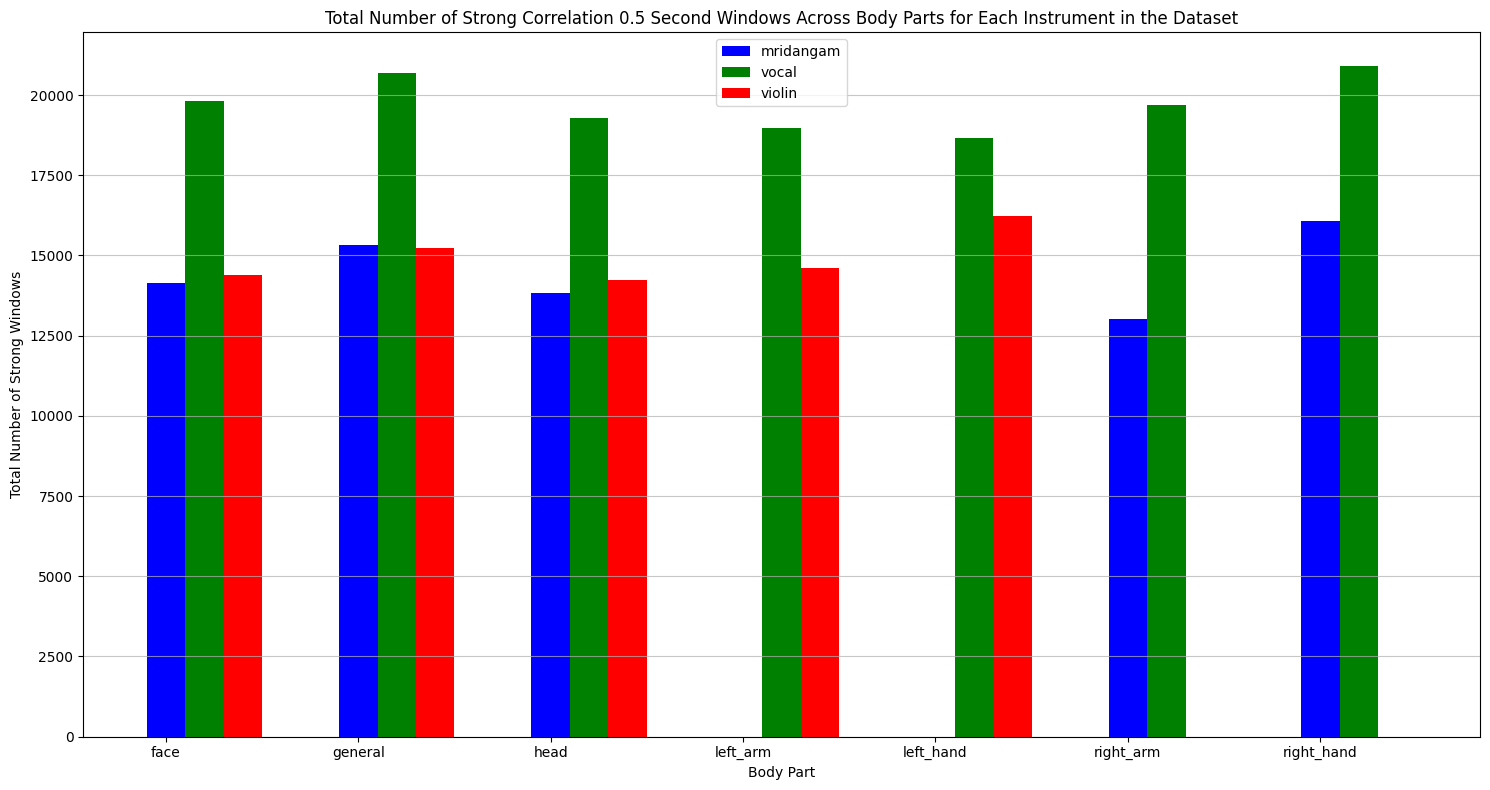

In [14]:
import matplotlib.pyplot as plt

body_parts_all = set()
body_part_counts = {instrument: {} for instrument in instruments}

# Aggregate counts across all artists and songs
for artist in strong_windows.keys():
    for song in strong_windows[artist].keys():
        for instrument in strong_windows[artist][song].keys():
            for body_part in strong_windows[artist][song][instrument].keys():
                speed_count = len(
                    [
                        w
                        for w in strong_windows[artist][song][instrument][
                            body_part
                        ]["speed"]
                        if abs(w[1]) > 0.66
                    ]
                )
                accel_count = len(
                    [
                        w
                        for w in strong_windows[artist][song][instrument][
                            body_part
                        ]["accel"]
                        if abs(w[1]) > 0.66
                    ]
                )
                total_count = speed_count + accel_count

                body_part_name = body_part
                body_parts_all.add(body_part_name)
                if body_part_name not in body_part_counts[instrument]:
                    body_part_counts[instrument][body_part_name] = 0
                body_part_counts[instrument][body_part_name] += total_count

# Prepare data for plotting
body_parts_list = sorted(list(body_parts_all))
num_body_parts = len(body_parts_list)
x = np.arange(num_body_parts)
width = 0.2  # Width of each bar

plt.figure(figsize=(15, 8))

colors = ["blue", "green", "red"]  # Colors for each instrument

for i, instrument in enumerate(instruments):
    counts = [
        body_part_counts[instrument].get(part, 0) for part in body_parts_list
    ]
    plt.bar(
        x + (i * width), counts, width=width, label=instrument, color=colors[i]
    )

plt.xlabel("Body Part")
plt.ylabel("Total Number of Strong Windows")
plt.title(
    "Total Number of Strong Correlation 0.5 Second Windows Across Body Parts for Each Instrument in the Dataset"
)
plt.xticks(x, body_parts_list)  # Set x-axis labels and rotate
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis="y", alpha=0.7)
plt.legend()
plt.show()

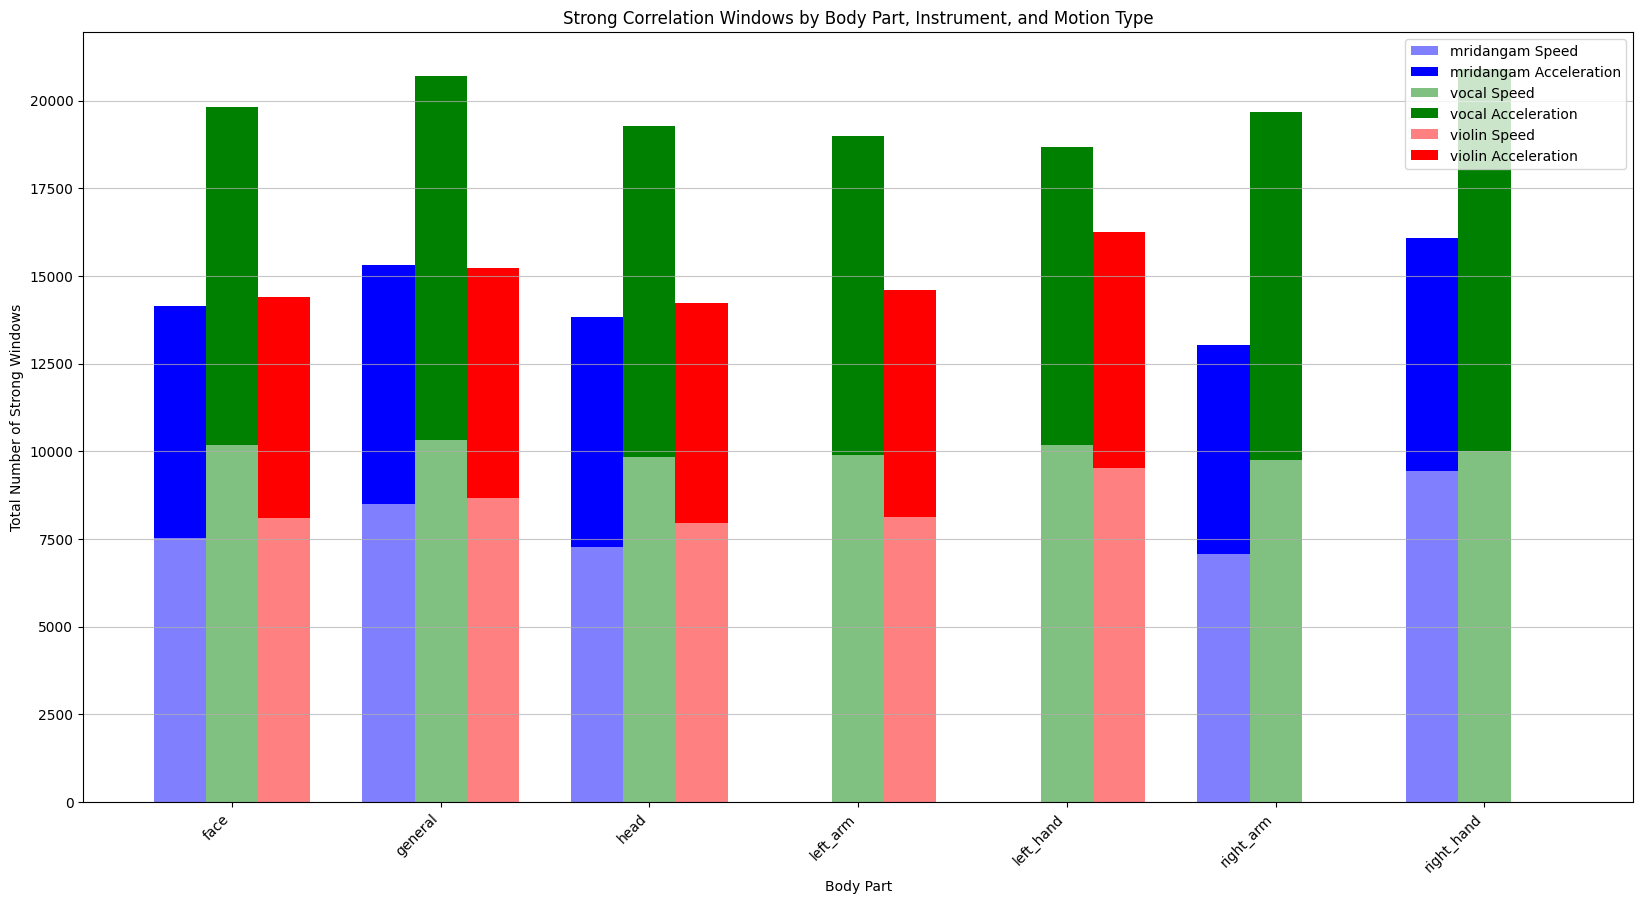

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# --- Data Aggregation ---
body_parts_all = set()
# Initialize with a nested dictionary for speed and accel counts
body_part_counts = {instrument: {} for instrument in instruments}

# Aggregate counts across all artists and songs
for artist in strong_windows.keys():
    for song in strong_windows[artist].keys():
        for instrument in strong_windows[artist][song].keys():
            # Ensure we only process instruments specified in the env
            if instrument not in instruments:
                continue
            for body_part, data in strong_windows[artist][song][instrument].items():
                body_parts_all.add(body_part)
                
                speed_count = len([w for w in data["speed"] if abs(w[1]) > 0.66])
                accel_count = len([w for w in data["accel"] if abs(w[1]) > 0.66])

                if body_part not in body_part_counts[instrument]:
                    body_part_counts[instrument][body_part] = {"speed": 0, "accel": 0}
                
                body_part_counts[instrument][body_part]["speed"] += speed_count
                body_part_counts[instrument][body_part]["accel"] += accel_count

# --- Plotting ---
body_parts_list = sorted(list(body_parts_all))
num_body_parts = len(body_parts_list)
x = np.arange(num_body_parts)  # the label locations
num_instruments = len(instruments)
width = 0.25  # the width of the bars

plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

# Define base colors and create lighter versions for speed
base_colors = ["blue", "green", "red"]
light_colors = []
for color in base_colors:
    rgb = mcolors.to_rgb(color)
    # Create a lighter version by mixing with white
    light_rgb = [1 - 0.5 * (1 - c) for c in rgb]
    light_colors.append(light_rgb)

for i, instrument in enumerate(instruments):
    # Get speed and acceleration counts for each body part
    speed_counts = np.array([
        body_part_counts[instrument].get(part, {"speed": 0})["speed"] for part in body_parts_list
    ])
    accel_counts = np.array([
        body_part_counts[instrument].get(part, {"accel": 0})["accel"] for part in body_parts_list
    ])
    
    # Position of the bar for the current instrument, centering the group
    x_pos = x + (i - (num_instruments - 1) / 2) * width

    # Plot the stacked bars
    ax.bar(x_pos, speed_counts, width, label=f'{instrument} Speed', color=light_colors[i])
    ax.bar(x_pos, accel_counts, width, bottom=speed_counts, label=f'{instrument} Acceleration', color=base_colors[i])

# Add some text for labels, title and axes ticks
ax.set_xlabel("Body Part")
ax.set_ylabel("Total Number of Strong Windows")
ax.set_title("Strong Correlation Windows by Body Part, Instrument, and Motion Type")
ax.set_xticks(x)
ax.set_xticklabels(body_parts_list, rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.7)

### Cross-Correlation Study

In [12]:
from scipy.signal import correlate
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from tqdm import tqdm

In [13]:
def normalize_window(data_window):
    """Normalize a window of data by subtracting mean and dividing by standard deviation."""
    return (data_window - np.mean(data_window)) / np.std(data_window)

In [14]:
def compute_cross_correlation(motion_window, audio_window, max_lag):
    """Compute cross-correlation between motion and audio windows."""
    # Normalize window data
    motion_norm = normalize_window(motion_window)
    audio_norm = normalize_window(audio_window)
    # Cross-correlation
    full_corr = correlate(motion_norm, audio_norm, mode="full")
    mid = len(full_corr) // 2
    return full_corr[mid - max_lag : mid + max_lag + 1]

In [15]:
def resample_to_30fps(data, original_fps):
    """Resample a 1D array to 30 fps using linear interpolation."""
    if original_fps == 30:
        return np.array(data)
    n_samples = len(data)
    duration = n_samples / original_fps
    t_original = np.linspace(0, duration, n_samples, endpoint=False)
    n_new = int(duration * 30)
    t_new = np.linspace(0, duration, n_new, endpoint=False)
    f = interp1d(t_original, data, kind='linear', fill_value="extrapolate")
    return f(t_new)

In [16]:
def process_feature_pair(motion_feature, audio_feature, instrument, feature_pair, 
                        window_size_frames, max_lag, all_correlations, original_fps):
    """Process a single feature pair for a recording, resampling to 30fps."""
    # Convert to numpy arrays and handle NaN values
    motion_array = np.array(motion_feature)
    audio_array = np.array(audio_feature)
    valid_indices = ~np.isnan(motion_array)
    motion = motion_array[valid_indices]
    audio = audio_array[valid_indices]

    # Resample to 30fps
    motion = resample_to_30fps(motion, original_fps)
    audio = resample_to_30fps(audio, original_fps)

    if len(motion) < window_size_frames:
        return  # Skip if not enough data for a window

    # Process in windows
    num_windows = len(motion) // window_size_frames
    for w in range(num_windows):
        start_idx = w * window_size_frames
        end_idx = start_idx + window_size_frames

        motion_window = motion[start_idx:end_idx]
        audio_window = audio[start_idx:end_idx]

        # Skip windows with little variation
        if np.std(motion_window) < 1e-6 or np.std(audio_window) < 1e-6:
            continue

        # Compute cross-correlation
        corr = compute_cross_correlation(motion_window, audio_window, max_lag)

        # Store correlation results by instrument and globally
        all_correlations[instrument][feature_pair].append(corr)
        all_correlations["global"][feature_pair].append(corr)

In [17]:
def process_recordings_30fps(motion_features, audio_features, dataset_metadata, 
                            feature_pairs, window_size_sec, instruments):
    """Process all recordings and compute windowed cross-correlations, enforcing 30fps."""
    all_correlations = {
        "global": {pair: [] for pair in feature_pairs},
        **{instr: {pair: [] for pair in feature_pairs} for instr in instruments}
    }
    lags = np.arange(-30, 31)  # For 1 second lag at 30fps

    for artist in tqdm(motion_features.keys(), desc="Processing artists"):
        for song in tqdm(motion_features[artist].keys(), desc="Processing songs", leave=False):
            original_fps = dataset_metadata[artist][song]["fps"]
            if original_fps is None:
                print(f"Missing FPS information for {artist}/{song}, skipping.")
                continue

            for instrument in motion_features[artist][song].keys():
                if instrument not in instruments:
                    continue

                for motion_type, audio_type in feature_pairs:
                    try:
                        motion_feature = motion_features[artist][song][instrument]["general"][motion_type]
                        audio_feature = audio_features[artist][song][instrument][audio_type]
                        process_feature_pair(
                            motion_feature, audio_feature, instrument,
                            (motion_type, audio_type), int(window_size_sec * 30), 30,
                            all_correlations, original_fps
                        )
                    except Exception as e:
                        print(f"Error processing {artist}/{song}/{instrument}/{motion_type}-{audio_type}: {e}")
                        break

    return all_correlations, lags

In [34]:
def plot_results(all_correlations, feature_pairs, lags, fps, instruments):
    """Plot cross-correlation results for each category and feature pair."""
    for category in ["global"] + instruments:
        plt.figure(figsize=(15, 10))
        plt.suptitle(f"Cross-correlation results for: {category.capitalize()}", fontsize=30)
        
        for i, pair in enumerate(feature_pairs, 1):
            if all_correlations[category][pair]:  # Check if we have data
                mean_corr = np.mean(all_correlations[category][pair], axis=0)
                std_corr = np.std(all_correlations[category][pair], axis=0)
                
                plt.subplot(2, 2, i)
                plt.plot(lags / fps, mean_corr, "b-", label="Mean")
                plt.fill_between(
                    lags / fps,
                    mean_corr - std_corr,
                    mean_corr + std_corr,
                    alpha=0.2,
                    color="b",
                    label="±1 std",
                )
                
                # Find and mark the maximum correlation
                max_idx = np.argmax(np.abs(mean_corr))
                max_corr = mean_corr[max_idx]
                max_lag_time = lags[max_idx] / fps
                
                plt.plot(max_lag_time, max_corr, "ro")
                plt.text(
                    max_lag_time,
                    max_corr,
                    f"\nlag: {max_lag_time:.2f}s\ncorr: {max_corr:.2f}",
                    verticalalignment="bottom",
                    fontsize=16
                )
                
                plt.xlabel("Lag (s)", fontsize=16)
                plt.ylabel("Cross-correlation", fontsize=16)
                plt.title(f"{pair[0]} vs {pair[1]}", fontsize=22)
                plt.grid(True)
                plt.legend(fontsize=16)
            else:
                plt.subplot(2, 2, i)
                plt.text(0.5, 0.5, "No data available", 
                        horizontalalignment='center', verticalalignment='center')
                plt.title(f"{pair[0]} vs {pair[1]}", fontsize=26)
                
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for suptitle
        plt.show()

In [25]:
def print_summary(all_correlations, feature_pairs, lags, fps, instruments):
    """Print summary statistics of optimal lags for each category and feature pair."""
    print("Summary of optimal lags (in seconds):")
    print("=====================================")
    for category in ["global"] + instruments:
        print(f"\n{category.capitalize()}:")
        for pair in feature_pairs:
            if all_correlations[category][pair]:
                mean_corr = np.mean(all_correlations[category][pair], axis=0)
                max_idx = np.argmax(np.abs(mean_corr))
                max_corr = mean_corr[max_idx]
                max_lag_time = lags[max_idx] / fps
                print(f"  {pair[0]} vs {pair[1]}: lag = {max_lag_time:.3f}s, corr = {max_corr:.3f}")
            else:
                print(f"  {pair[0]} vs {pair[1]}: No data")

In [26]:
feature_pairs = [
    ("mean_speed", "onset_env"),
    ("mean_speed", "rms"),
    ("mean_acceleration", "onset_env"),
    ("mean_acceleration", "rms"),
]
window_size_sec = 5

# Process all recordings
all_correlations, lags = process_recordings_30fps(
    motion_features, audio_features, dataset_metadata,
    feature_pairs, window_size_sec, instruments
)

Processing artists: 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]


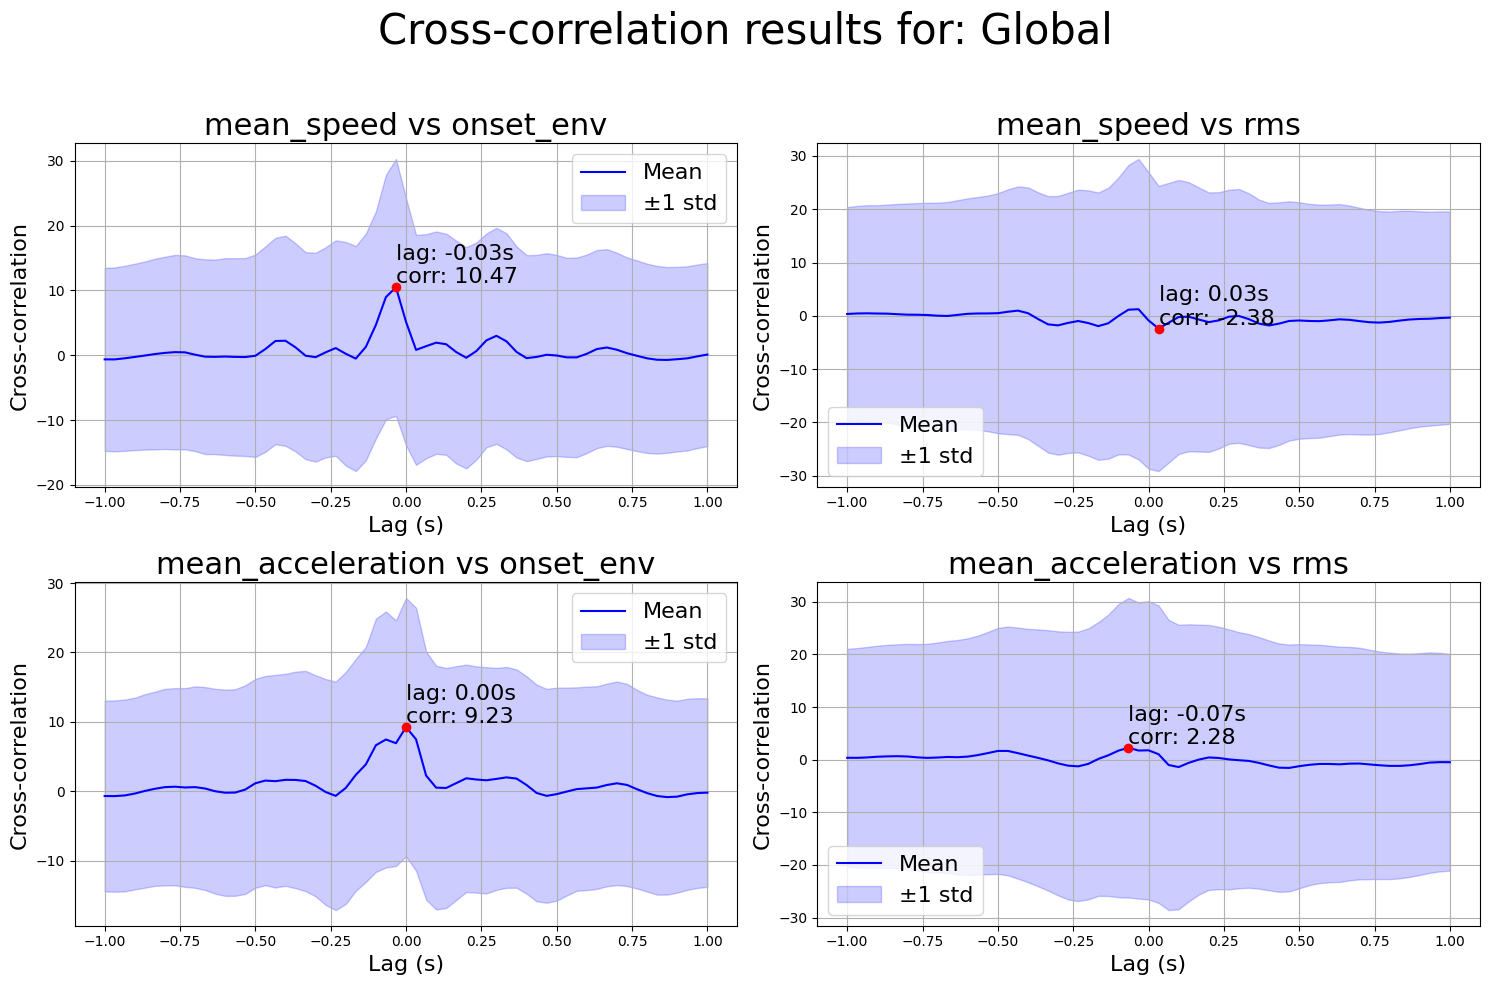

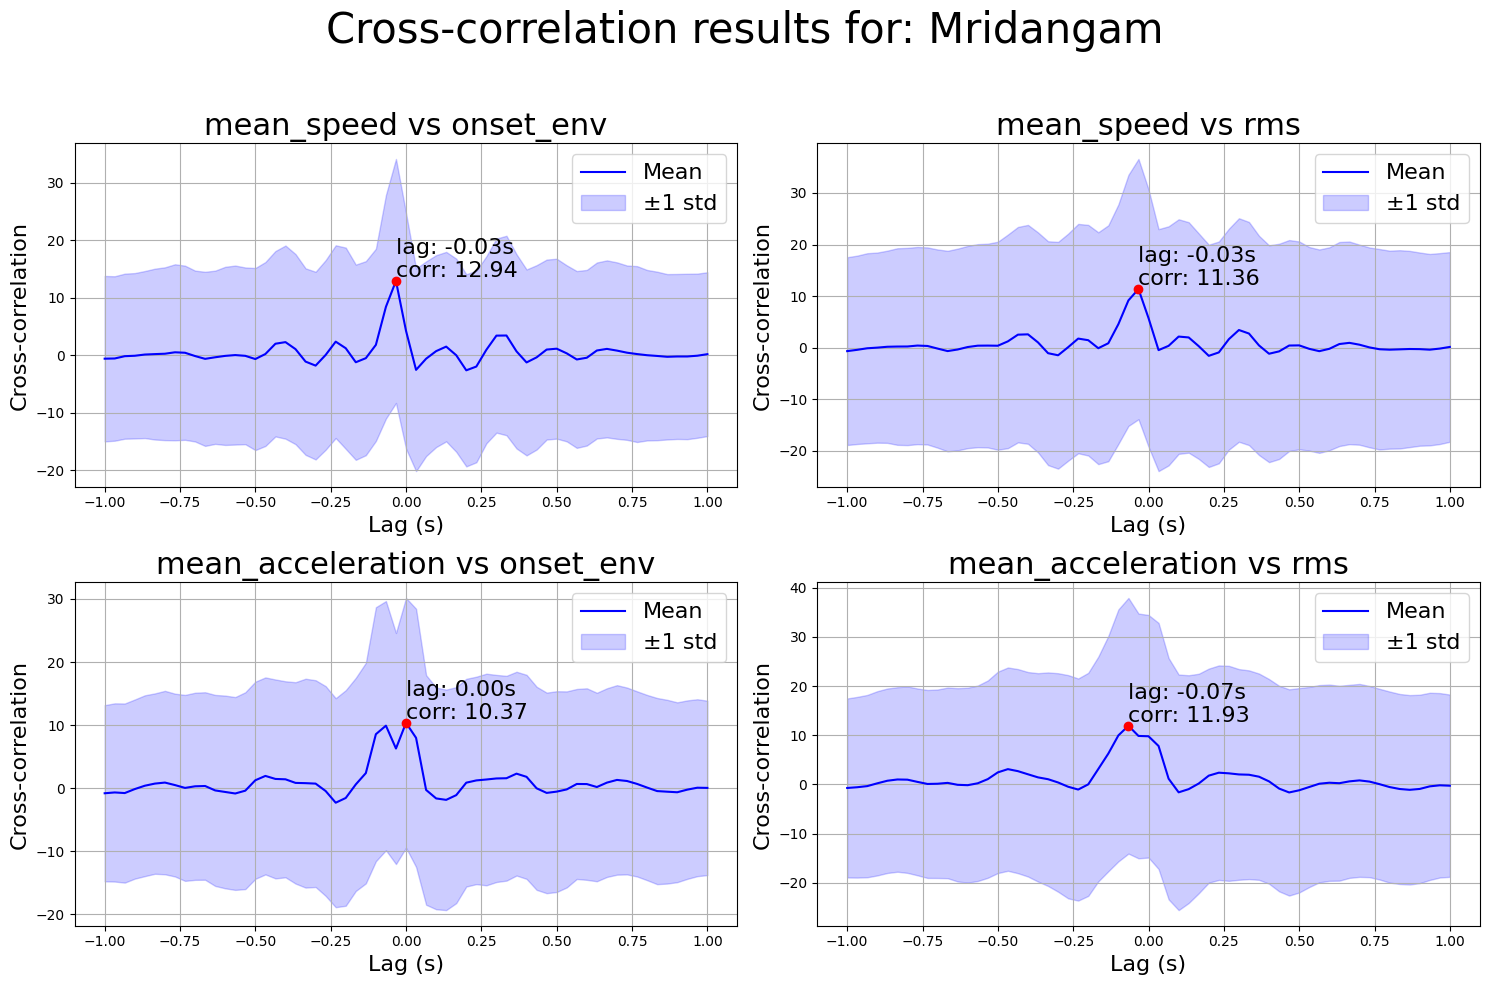

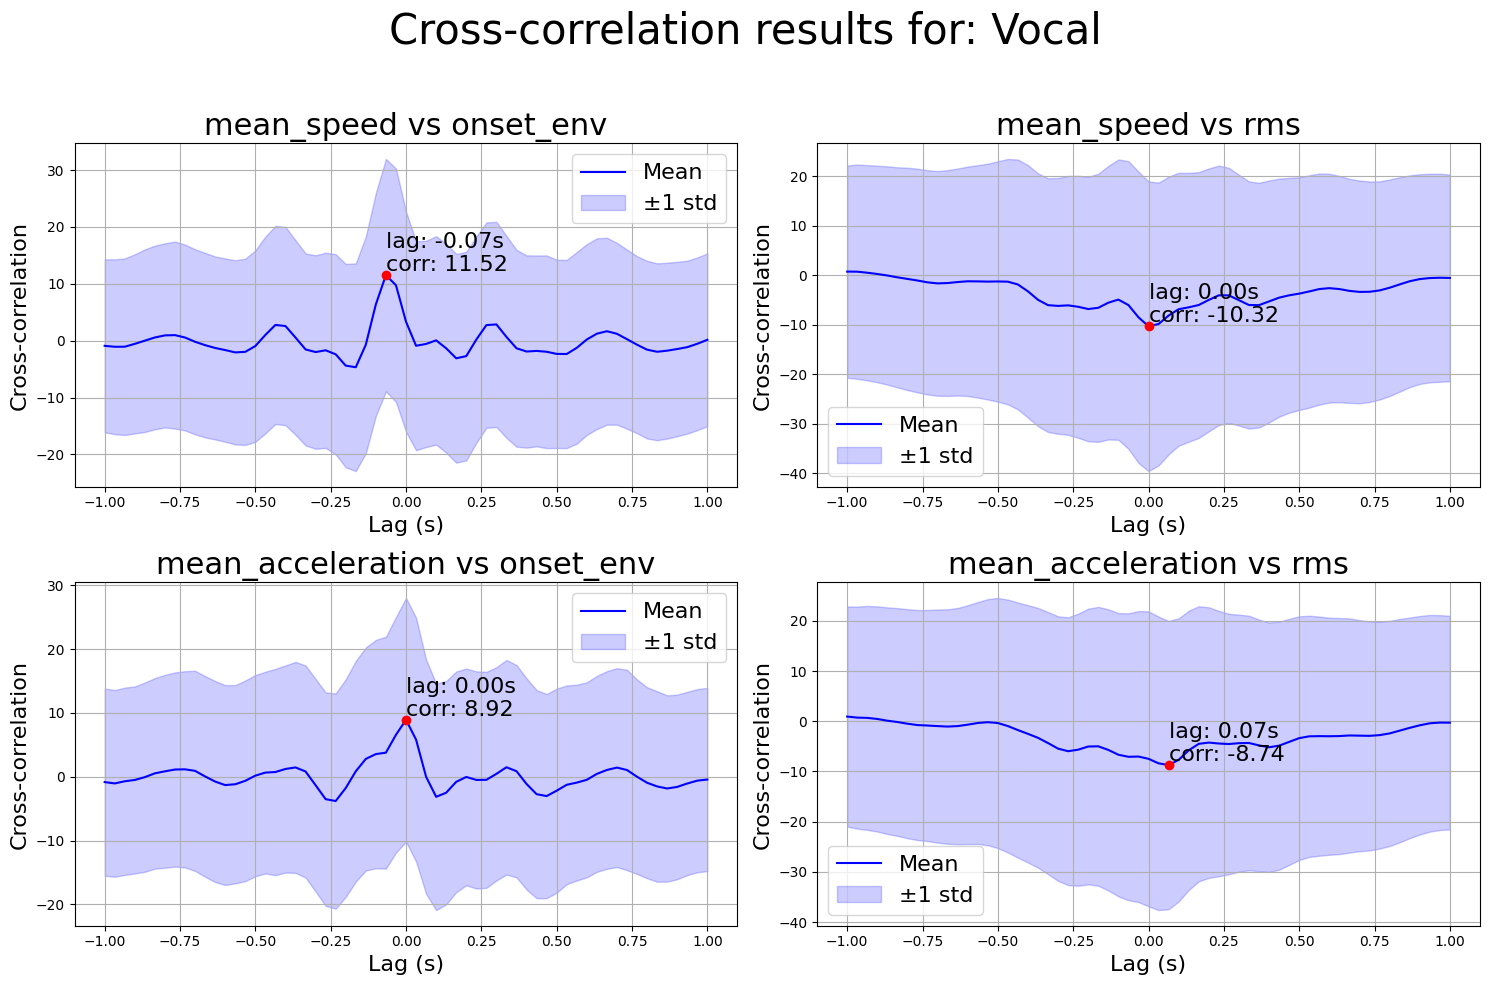

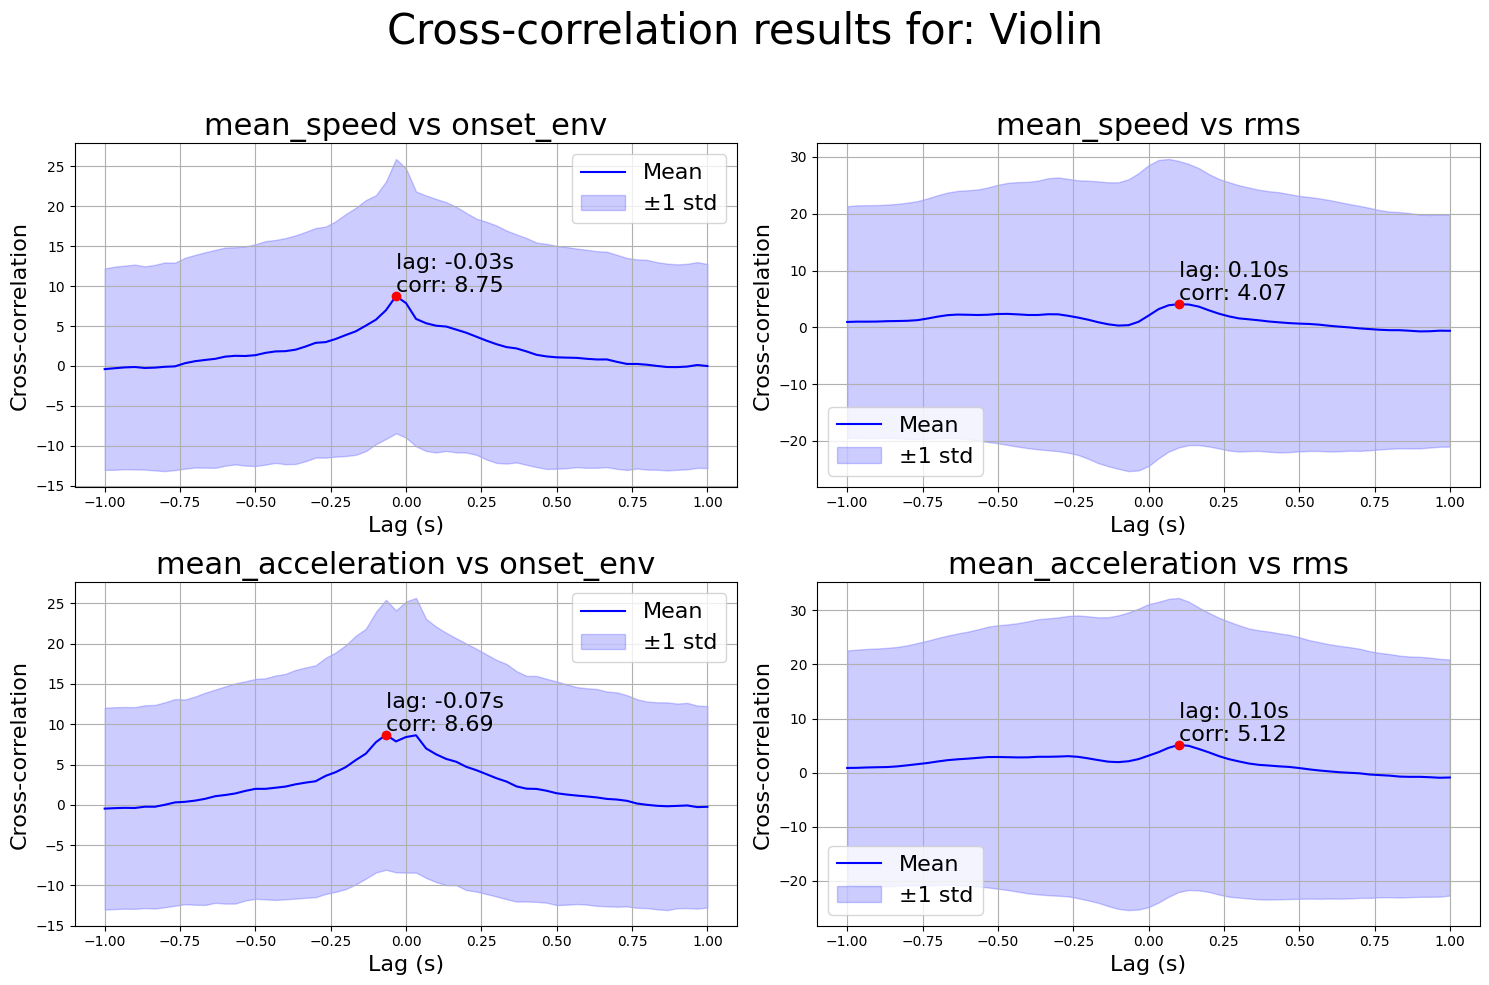

Summary of optimal lags (in seconds):

Global:
  mean_speed vs onset_env: lag = -0.033s, corr = 10.471
  mean_speed vs rms: lag = 0.033s, corr = -2.383
  mean_acceleration vs onset_env: lag = 0.000s, corr = 9.230
  mean_acceleration vs rms: lag = -0.067s, corr = 2.281

Mridangam:
  mean_speed vs onset_env: lag = -0.033s, corr = 12.940
  mean_speed vs rms: lag = -0.033s, corr = 11.361
  mean_acceleration vs onset_env: lag = 0.000s, corr = 10.369
  mean_acceleration vs rms: lag = -0.067s, corr = 11.931

Vocal:
  mean_speed vs onset_env: lag = -0.067s, corr = 11.520
  mean_speed vs rms: lag = 0.000s, corr = -10.320
  mean_acceleration vs onset_env: lag = 0.000s, corr = 8.922
  mean_acceleration vs rms: lag = 0.067s, corr = -8.736

Violin:
  mean_speed vs onset_env: lag = -0.033s, corr = 8.747
  mean_speed vs rms: lag = 0.100s, corr = 4.074
  mean_acceleration vs onset_env: lag = -0.067s, corr = 8.690
  mean_acceleration vs rms: lag = 0.100s, corr = 5.119


In [35]:
plot_results(all_correlations, feature_pairs, lags, 30, instruments)
print_summary(all_correlations, feature_pairs, lags, 30, instruments)